# Open Loop: Brightness Scan

This example includes a brightness scan that is plotted to show the trend.

## Import necessary Python modules

In [1]:
import numpy as np
import epics # 'epics' is part of pyepics
from time import sleep
import matplotlib.pyplot as plt

## Establish initial settings for LEDs, Shutter, and Photodetector

In [2]:
NLEDS = 6 # our sidekick system has six LEDs
for i in range(NLEDS): # for each of our six LEDs
    epics.caput('LEDS:CH' + str(i) + ':brig.VAL', 255) # Set LED brightness to 255 out of 255 (max brightness)
    epics.caput('LEDS:CH' + str(i) + ':dur.VAL', 500e3) # Set LED 'flash on' duration to 500 ms

epics.caput("SHUTTER:enable", 1) # Enable the shutter
epics.caput("SHUTTER:dur", 1.5e6) # Set shutter 'open' duration to 1.5 seconds (includes some time while opening)
epics.caput("PULSEGEN:reprate", 1/3.0) # Set systemwide repetition rate to once every three seconds

epics.caput("PULSEGEN:CH0:delay", 400.0e3) # Set LED trigger delay to 400 ms
epics.caput("PULSEGEN:CH1:delay", 0.0e3) # Set Shutter trigger delay to 0 ms
epics.caput("PULSEGEN:CH2:delay", 300.0e3) # Set Photodetector trigger delay to 300 ms

epics.caput("PHOTO:dur", 1000.0e3) # Set photodetector exposure length to one second

1

## Write parser to interpret photodetector data string

In [3]:
epics.caget("PHOTO:data")

'DAT: 0.000063538617, TRIG: 31469'

In [4]:
def dataparse(datastr):
    """ Parse the photodetector data string, which comes in the format 'DATA: 0.02112776, TRIGCNT: 531' """
    [str1, str2] = datastr.split(',')
    data = np.float64(str1.split(': ')[1])
    trig = np.int64(str2.split(': ')[1])
    return data, trig

# Example usage:
dataparse("DATA: 0.02112776, TRIGCNT: 531")

(0.02112776, 531)

In [5]:
dataparse(epics.caget("PHOTO:data"))

(6.3538617e-05, 31469)

## Record photodetector signal (to NumPy array) while stepping through LED brightnesses

In [6]:
NSTEPS = 30 # We will explore brightness level in 30 distinct steps

brigs = np.linspace(0, 255, NSTEPS).astype('int') # Create a list NSTEPS long, that spans 0 to 255
data = np.zeros(NSTEPS) # allocate array to hold photodetector value for each brightness step
trigs = np.zeros(NSTEPS) # allocate array to hold trigger count corresponding to each photodetector value

for i in range(NSTEPS):
    print("Brightness: ", brigs[i])
    for j in range(NLEDS):
        epics.caput('LEDS:CH' + str(j) + ':brig.VAL', brigs[i])
    sleep(5)
    datastr = epics.caget("PHOTO:data")
    data[i], trigs[i] = dataparse(datastr)
    print(datastr)

Brightness:  0
DAT: 0.000000000000, TRIG: 31470
Brightness:  8
DAT: 0.000000000000, TRIG: 31472
Brightness:  17
DAT: 0.000000000000, TRIG: 31473
Brightness:  26
DAT: 0.000031364900, TRIG: 31475
Brightness:  35
DAT: 0.000300302230, TRIG: 31477
Brightness:  43
DAT: 0.000308977610, TRIG: 31478
Brightness:  52
DAT: 0.002718736200, TRIG: 31480
Brightness:  61
DAT: 0.004122816000, TRIG: 31482
Brightness:  70
DAT: 0.005415378100, TRIG: 31484
Brightness:  79
DAT: 0.006848624900, TRIG: 31485
Brightness:  87
DAT: 0.008078796800, TRIG: 31487
Brightness:  96
DAT: 0.009336062700, TRIG: 31489
Brightness:  105
DAT: 0.010575310000, TRIG: 31490
Brightness:  114
DAT: 0.011919329000, TRIG: 31492
Brightness:  123
DAT: 0.013212161000, TRIG: 31494
Brightness:  131
DAT: 0.014343145000, TRIG: 31495
Brightness:  140
DAT: 0.015662430000, TRIG: 31497
Brightness:  149
DAT: 0.016966093000, TRIG: 31499
Brightness:  158
DAT: 0.018187638000, TRIG: 31501
Brightness:  167
DAT: 0.019354144000, TRIG: 31502
Brightness:  1

## Plot recorded data to identify trend

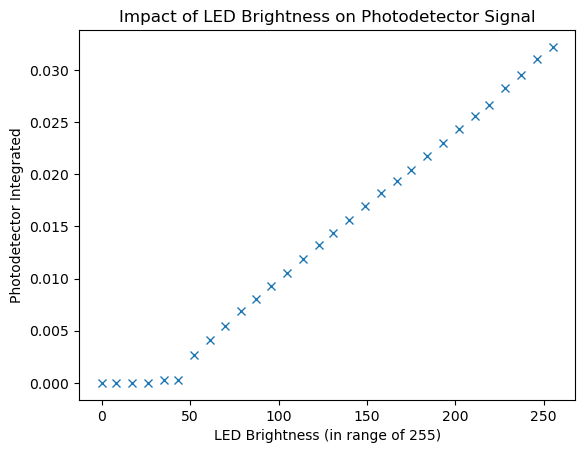

In [7]:
fig, ax = plt.subplots()
ax.plot(brigs, data, 'x')
ax.set_xlabel("LED Brightness (in range of 255)")
ax.set_ylabel("Photodetector Integrated")
ax.set_title("Impact of LED Brightness on Photodetector Signal")
plt.show()